In [1]:
import requests

import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tqdm import tqdm

In [2]:
labels = ["washing_hands", "shower", "flushing_toilet", "dishwasher", "washing_machine"]

In [3]:
# Get all data
data = requests.get("https://dolphin-app-9sdeq.ondigitalocean.app/api/v1/recordings").json()

recordings = []

for recording in data:
    recordings.append({
        "path": f'../recordings/combined/{recording["name"]}',
        "label": recording["label"],
        "environment": recording["environment"]
    })

dataframe = pd.json_normalize(recordings)

dataframe.head()

,path,label,environment
0,../recordings/combined/a196dbae-1f50-4d0e-b345...,washing_hands,marsberg
1,../recordings/combined/826e36b1-2a7e-4d22-9c81...,washing_hands,marsberg
2,../recordings/combined/9a6b6b01-e466-47fb-9fcc...,washing_hands,marsberg
3,../recordings/combined/84ee02e6-44d5-4ab3-b875...,washing_hands,marsberg
4,../recordings/combined/ec24c55a-39ec-4b36-86fe...,washing_hands,marsberg


In [4]:
# Function to extract features
def preprocess(dataframe):
    for index, row in tqdm(dataframe.iterrows()):
        audio, sample_rate = librosa.load(row["path"])
        
        # Calculate mean and variance of the MFCCs
        mfcc_stft = librosa.feature.mfcc(y=audio, sr=sample_rate)
        dataframe.at[index, "mfcc_mean"] = np.mean(mfcc_stft)
        dataframe.at[index, "mfcc_var"] = np.var(mfcc_stft)
        
        # Calculate number of samples, representing length
        dataframe.at[index, "n_samples"] = audio.shape[0]

        # Calculate mean and variance of the chromagram
        chroma_stft = librosa.feature.chroma_stft(y=audio, sr=sample_rate)
        dataframe.at[index, "chroma_mean"] = np.mean(chroma_stft)
        dataframe.at[index, "chroma_var"] = np.var(chroma_stft)
        
        # Calculate mean and variance of the root mean square array
        rms = librosa.feature.rms(y=audio)
        dataframe.at[index, "rms_mean"] = np.mean(rms)
        dataframe.at[index, "rms_var"] = np.var(rms)
        
        # Calculate mean and variance of the spectral centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)
        dataframe.at[index, "sc_mean"] = np.mean(spectral_centroid)
        dataframe.at[index, "sc_var"] = np.var(spectral_centroid)
        
    return dataframe

dataframe = preprocess(dataframe)

119it [04:15,  2.15s/it]


In [5]:
# Extract separate dataframes for environments marsberg and duesseldorf
dataframe_marsberg = dataframe[dataframe["environment"] == "marsberg"]
dataframe_duesseldorf = dataframe[dataframe["environment"] == "duesseldorf"]

In [6]:
washing_hands_marsberg_samples = dataframe_marsberg[dataframe_marsberg['label']=="washing_hands"]
shower_marsberg_samples = dataframe_marsberg[dataframe_marsberg['label']=="shower"]
flushing_toilet_marsberg_samples = dataframe_marsberg[dataframe_marsberg['label']=="flushing_toilet"]
dishwasher_marsberg_samples = dataframe_marsberg[dataframe_marsberg['label']=="dishwasher"]
washing_machine_marsberg_samples = dataframe_marsberg[dataframe_marsberg['label']=="washing_machine"]

In [7]:
washing_hands_duesseldorf_samples = dataframe_duesseldorf[dataframe_duesseldorf['label']=="washing_hands"]
shower_duesseldorf_samples = dataframe_duesseldorf[dataframe_duesseldorf['label']=="shower"]
flushing_toilet_duesseldorf_samples = dataframe_duesseldorf[dataframe_duesseldorf['label']=="flushing_toilet"]
dishwasher_duesseldorf_samples = dataframe_duesseldorf[dataframe_duesseldorf['label']=="dishwasher"]
washing_machine_duesseldorf_samples = dataframe_duesseldorf[dataframe_duesseldorf['label']=="washing_machine"]

In [8]:
def violin_plot(feature_name, variable_1, variable_2=None):
    ncols = 2 if variable_2 else 1
    fig, ax = plt.subplots(nrows=2, ncols=ncols, sharex="col", sharey=True, figsize=(10, 8))

    sns.set_theme()

    variable_1_marsberg = sns.violinplot(
        data=[
            [washing_hands_marsberg_samples[variable_1]],
            [shower_marsberg_samples[variable_1]],
            [flushing_toilet_marsberg_samples[variable_1]],
            [dishwasher_marsberg_samples[variable_1]],
            [washing_machine_marsberg_samples[variable_1]]       
        ],
        inner="points",
        orient="h",
        ax=(ax[0][0] if variable_2 else ax[0])
    )

    if(variable_2):
        variable_2_marsberg = sns.violinplot(
            data=[
                [washing_hands_marsberg_samples[variable_2]],
                [shower_marsberg_samples[variable_2]],
                [flushing_toilet_marsberg_samples[variable_2]],
                [dishwasher_marsberg_samples[variable_2]],
                [washing_machine_marsberg_samples[variable_2]]       
            ],
            inner="points",
            orient="h",
            ax=ax[0][1]
        )

    variable_1_duesseldorf = sns.violinplot(
        data=[
            [washing_hands_duesseldorf_samples[variable_1]],
            [shower_duesseldorf_samples[variable_1]],
            [flushing_toilet_duesseldorf_samples[variable_1]],
            [dishwasher_duesseldorf_samples[variable_1]],
            [washing_machine_duesseldorf_samples[variable_1]]       
        ],
        inner="points",
        orient="h",
        ax=(ax[1][0] if variable_2 else ax[1])
    )

    if variable_2:
        variable_2_duesseldorf = sns.violinplot(
            data=[
                [washing_hands_duesseldorf_samples[variable_2]],
                [shower_duesseldorf_samples[variable_2]],
                [flushing_toilet_duesseldorf_samples[variable_2]],
                [dishwasher_duesseldorf_samples[variable_2]],
                [washing_machine_duesseldorf_samples[variable_2]]       
            ],
            inner="points",
            orient="h",
            ax=ax[1][1]
        )

    variable_1_marsberg.set_yticklabels(labels);
    variable_1_marsberg.set_title(f'{feature_name}{" - Mean" if variable_2 else ""} - Marsberg');
    if variable_2:
        variable_2_marsberg.set_title(f'{feature_name} - Variance - Marsberg');

    variable_1_duesseldorf.set_yticklabels(labels);
    variable_1_duesseldorf.set_title(f'{feature_name}{" - Mean" if variable_2 else ""} - Duesseldorf');
    if variable_2:
        variable_2_duesseldorf.set_title(f'{feature_name} - Variance - Duesseldorf');
    
    plt.tight_layout();

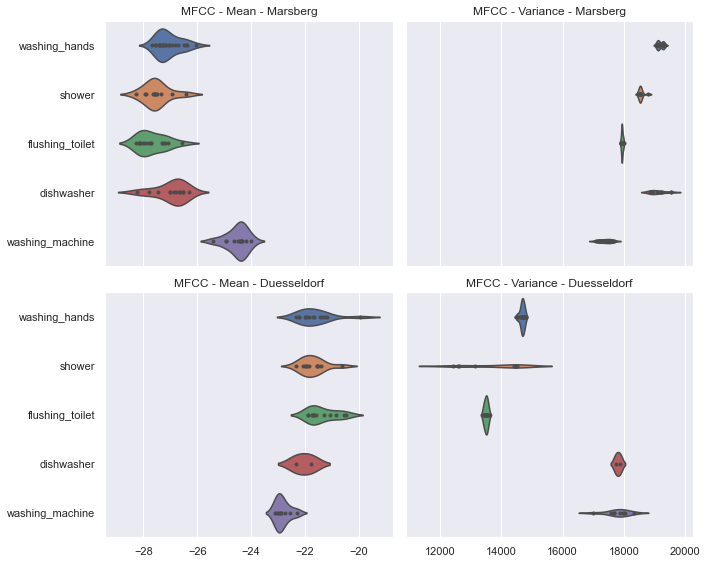

In [14]:
violin_plot("MFCC", "mfcc_mean", "mfcc_var")

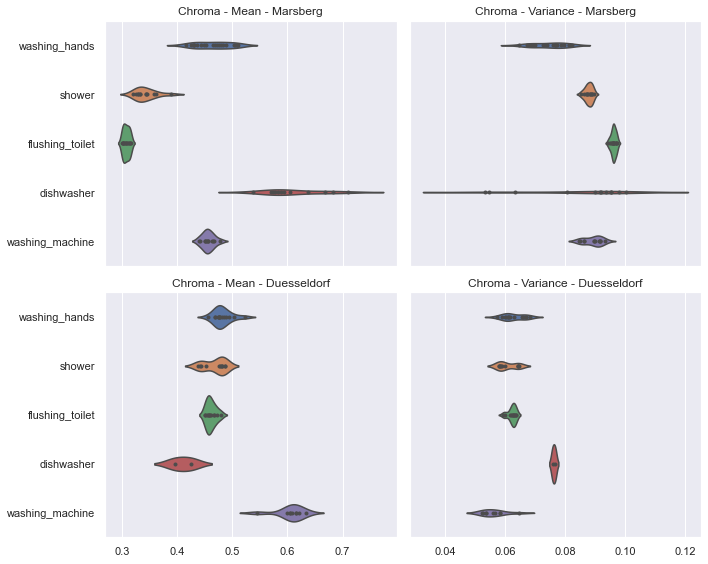

In [10]:
violin_plot("Chroma", "chroma_mean", "chroma_var")

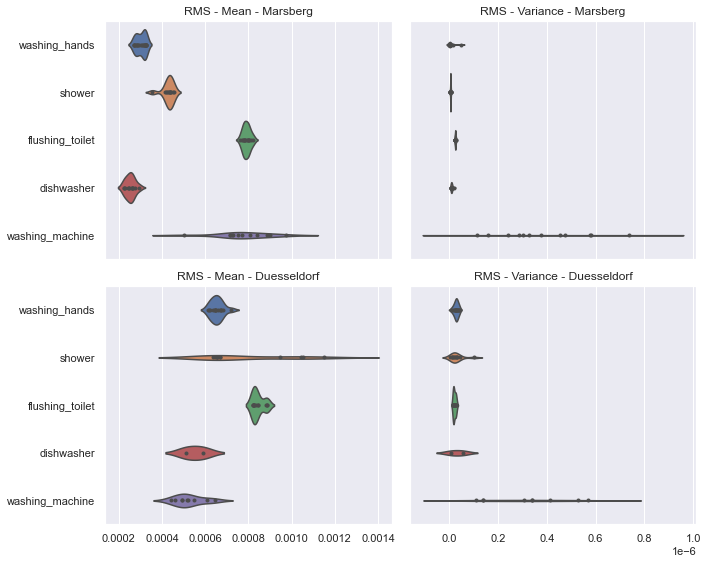

In [11]:
violin_plot("RMS", "rms_mean", "rms_var")

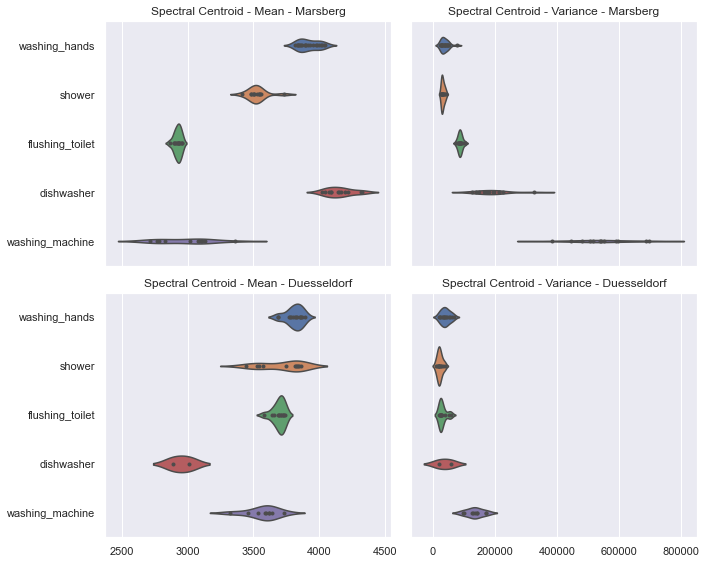

In [12]:
violin_plot("Spectral Centroid", "sc_mean", "sc_var")

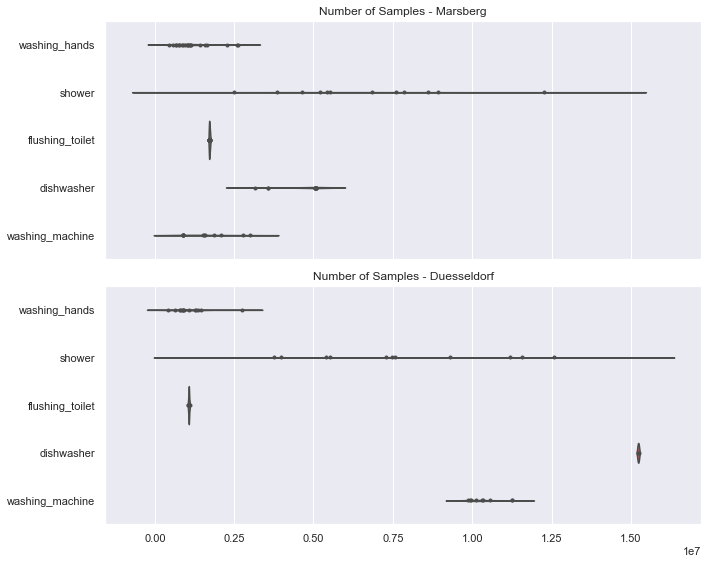

In [13]:
violin_plot("Number of Samples", "n_samples")